## § 8.3.	PCA

### § 8.3.2.	Principal Components

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation # added ex-post

In [2]:
# X = [...] # create a small 3D dataset

# added ex-post (generate a small 3D dataset: oval shape, rotated in 3D space, w/ points distributed unevenly, noise)
m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

### § 8.3.3.	Projecting Down to d Dimensions

In [4]:
W2 = Vt[:2].T
X2D = X_centered @ W2

### § 8.3.4.	Using Scikit-Learn

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

### § 8.3.5.	Explained Variance Ratio

In [7]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

### § 8.3.6.	Choosing the Right Number of Dimensions

In [8]:
from sklearn.datasets import fetch_openml

In [9]:
mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # d = 154

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [11]:
pca.n_components_

154

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

In [13]:
clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [14]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


### § 8.3.7.	PCA for Compression

In [15]:
X_recovered = pca.inverse_transform(X_reduced)

### § 8.3.8.	Randomized PCA

In [16]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### § 8.3.9.	Incremental PCA

In [17]:
from sklearn.decomposition import IncrementalPCA

In [18]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [19]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

In [20]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

## § 8.4.	Random Projection

In [21]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, e = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=e)
d

7300

In [22]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d) # std dev (square root of variance)

X = np.random.randn(m, n) # generate a fake dataset
X_reduced = X @ P.T

In [23]:
from sklearn.random_projection import GaussianRandomProjection

In [24]:
gaussian_rnd_proj = GaussianRandomProjection(eps=e, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X) # same result as above

In [25]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

## § 8.5.	LLE

In [26]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

In [27]:
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

## § 8.7.	Exercises

9) Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a random forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%. Train a new random forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next, evaluate the classifier on the test set. How does it compare to the previous classifier? Try again with an `SGDClassifier`. How much does PCA help now?

In [28]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

In [29]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [30]:
%time rnd_clf.fit(X_train, y_train)

CPU times: user 43 s, sys: 200 ms, total: 43.2 s
Wall time: 43.3 s


RandomForestClassifier(random_state=42)

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [35]:
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 1min 50s, sys: 244 ms, total: 1min 50s
Wall time: 1min 50s


RandomForestClassifier(random_state=42)

In [36]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

In [37]:
from sklearn.linear_model import SGDClassifier

In [38]:
sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

CPU times: user 2min 43s, sys: 215 ms, total: 2min 44s
Wall time: 2min 44s


SGDClassifier(random_state=42)

In [39]:
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.874

In [40]:
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 36 s, sys: 156 ms, total: 36.1 s
Wall time: 36 s


SGDClassifier(random_state=42)

In [41]:
y_pred = sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8959

10) Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class. Alternatively, you can replace each dot in the scatterplot with the corresponding instance's class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits the visualization will be too cluttered, sou you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms, such as PCA, LLE, or MDS, and compare the resulting visualizations.

In [42]:
X_sample, y_sample = X_train[:5000], y_train[:5000]

In [43]:
from sklearn.manifold import TSNE

In [44]:
tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
%time X_reduced = tsne.fit_transform(X_sample)

CPU times: user 1min 16s, sys: 188 ms, total: 1min 16s
Wall time: 45.4 s


In [46]:
import matplotlib.pyplot as plt

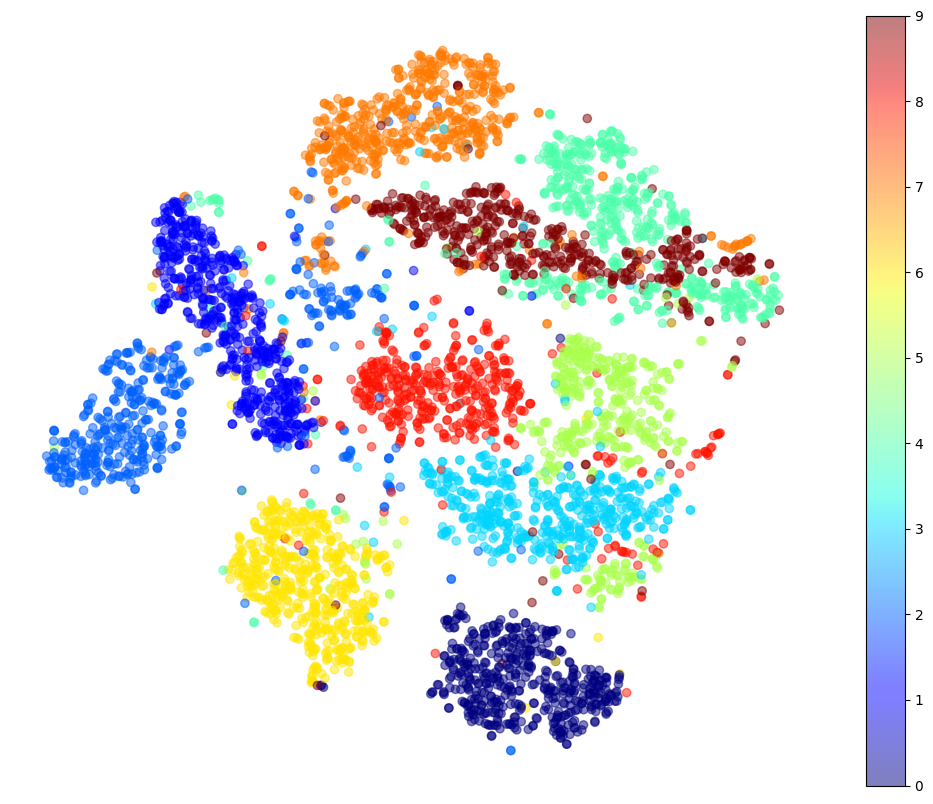

In [47]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

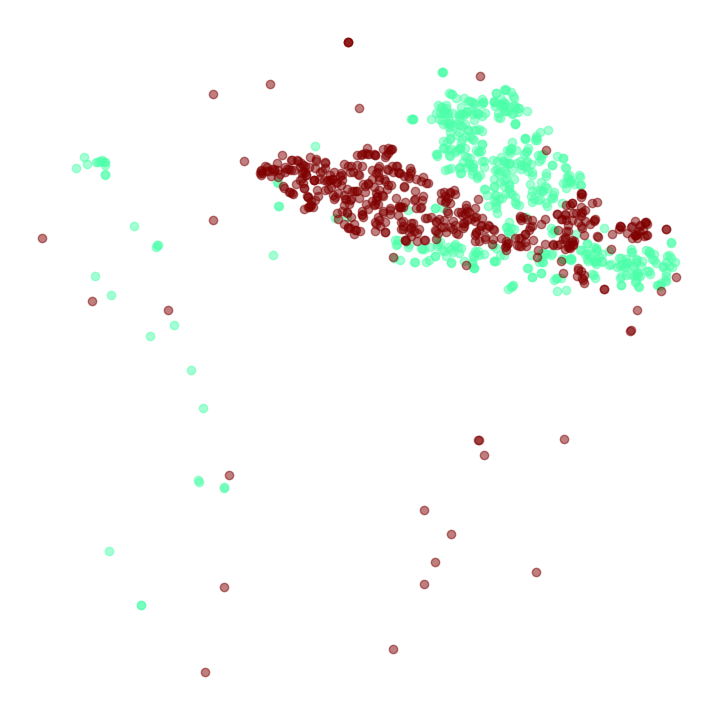

In [48]:
plt.figure(figsize=(9, 9))
cmap = plt.cm.jet
for digit in ('4', '9'):
  plt.scatter(X_reduced[y_sample == digit, 0], X_reduced[y_sample == digit, 1],
              c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis("off")
plt.show()

In [51]:
idx = (y_sample == "4") | (y_sample == '9')
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

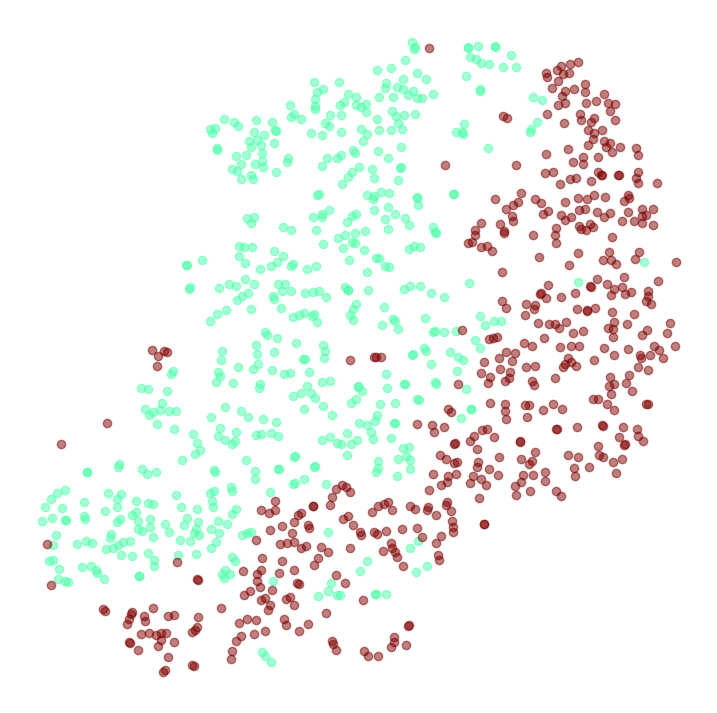

In [52]:
plt.figure(figsize=(9, 9))
for digit in ('4', '9'):
  plt.scatter(X_subset_reduced[y_subset == digit, 0],
              X_subset_reduced[y_subset == digit, 1],
              c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

In [53]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [54]:
def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
  # Let's sclae the input features so that they range from 0 to 1
  X_normalized = MinMaxScaler().fit_transform(X)
  # Now we create the list of coordinates of the digits plotted so far. We pretend that
  # one is already plotted far away at the start, to avoid 'if' statements in the loop below
  neighbors = np.array([[10., 10.]])
  # The rest should be self-explanatory ;)
  plt.figure(figsize=figsize)
  cmap = plt.cm.jet
  digits = np.unique(y)
  for digit in digits:
    plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
  plt.axis("off")
  ax = plt.gca() # get current axes
  for index, image_coord in enumerate(X_normalized):
    closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
    if closest_distance > min_distance:
      neighbors = np.r_[neighbors, [image_coord]]
      if images is None:
        plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                 color=cmap(float(y[index]) / 9),
                 fontdict={"weight": "bold", "size": 16})
      else:
        image = images[index].reshape(28, 28)
        imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
        ax.add_artist(imagebox)

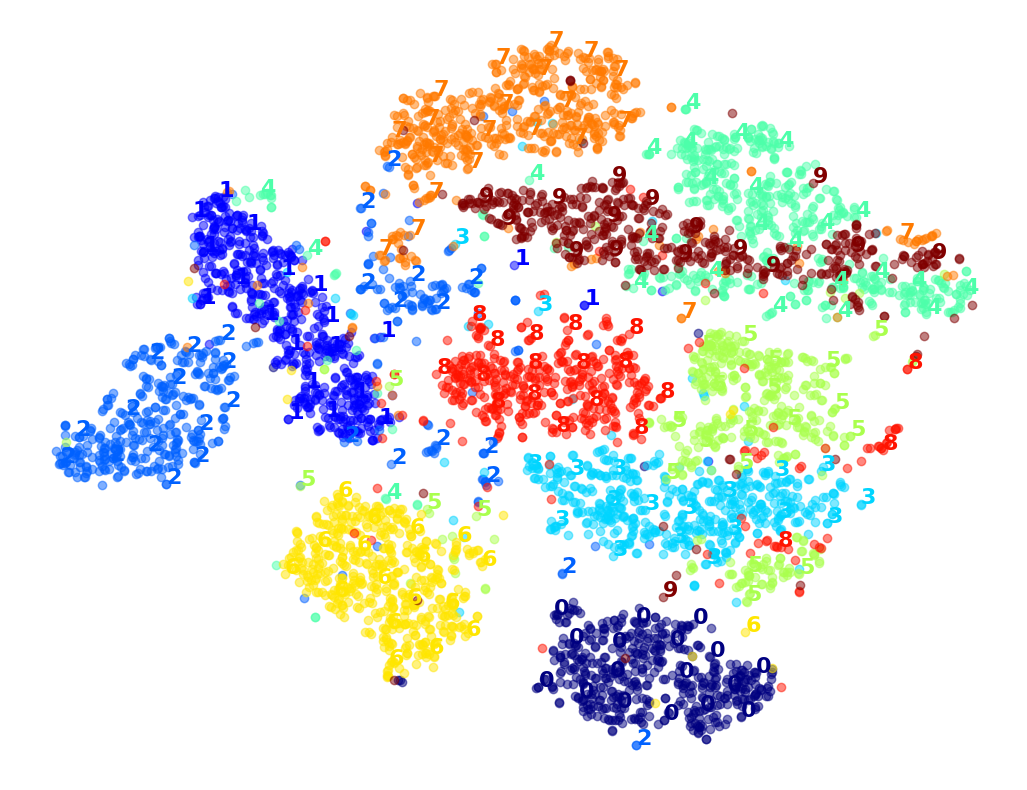

In [55]:
plot_digits(X_reduced, y_sample)

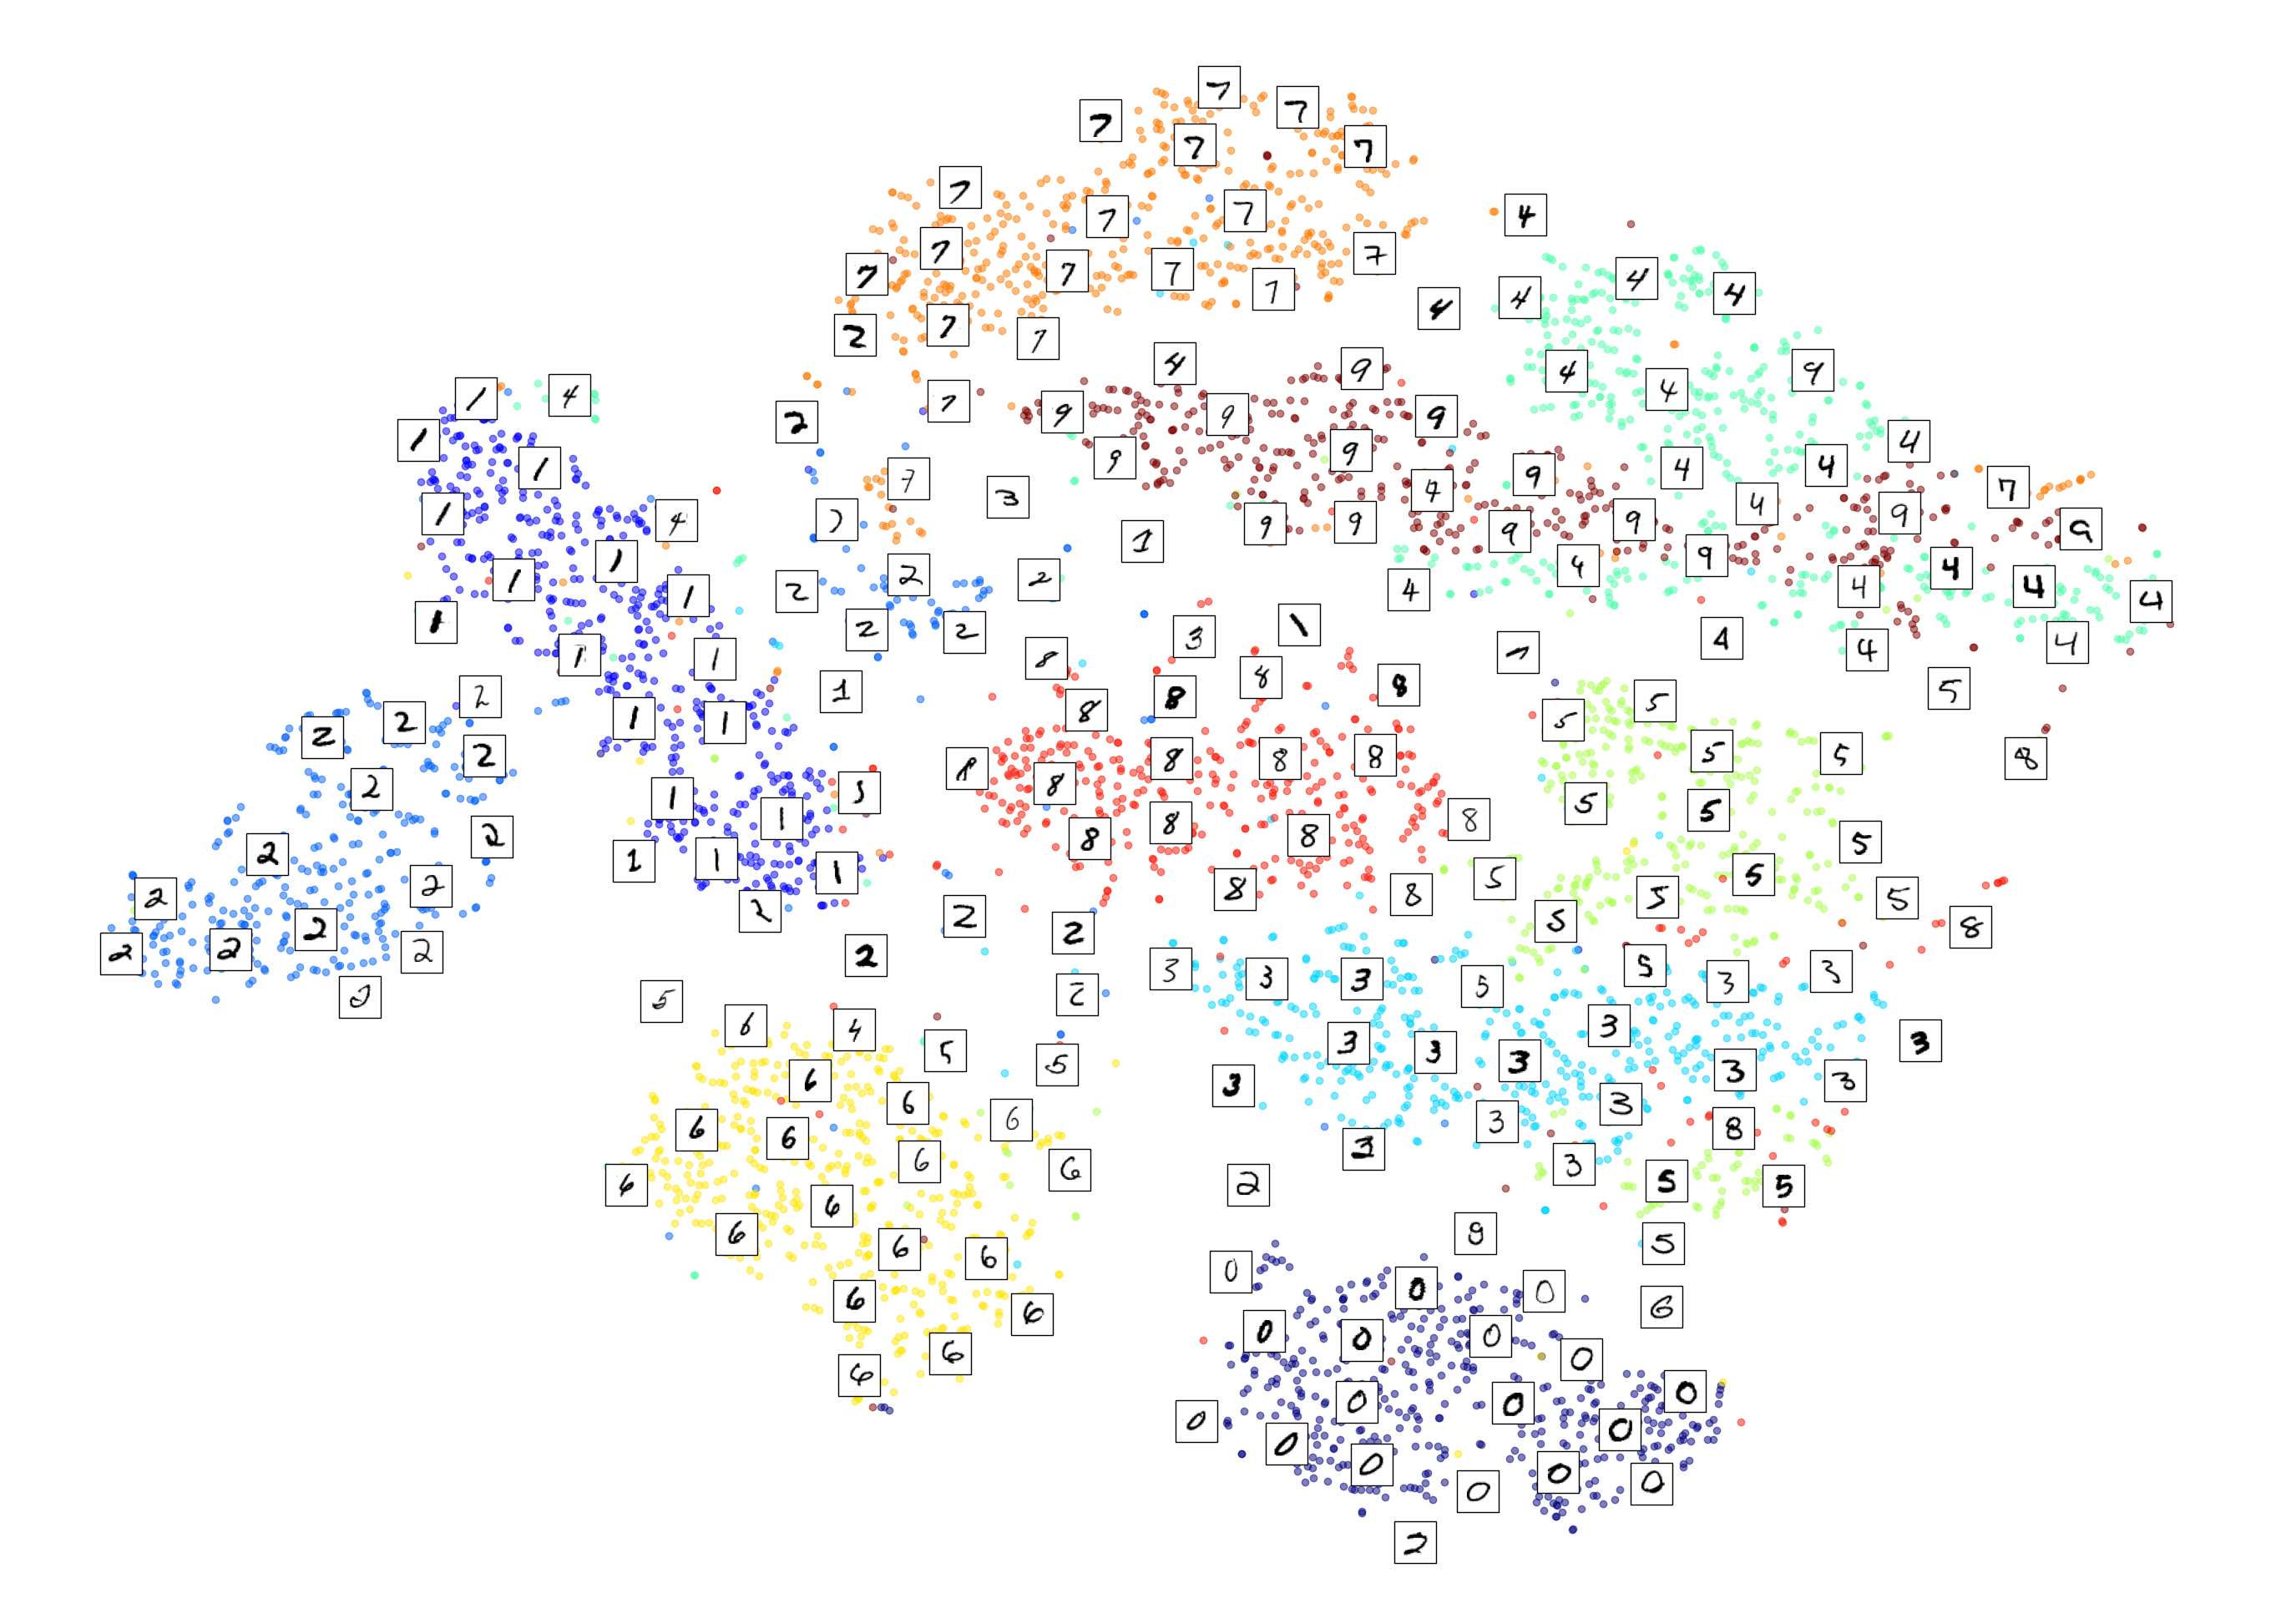

In [56]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))

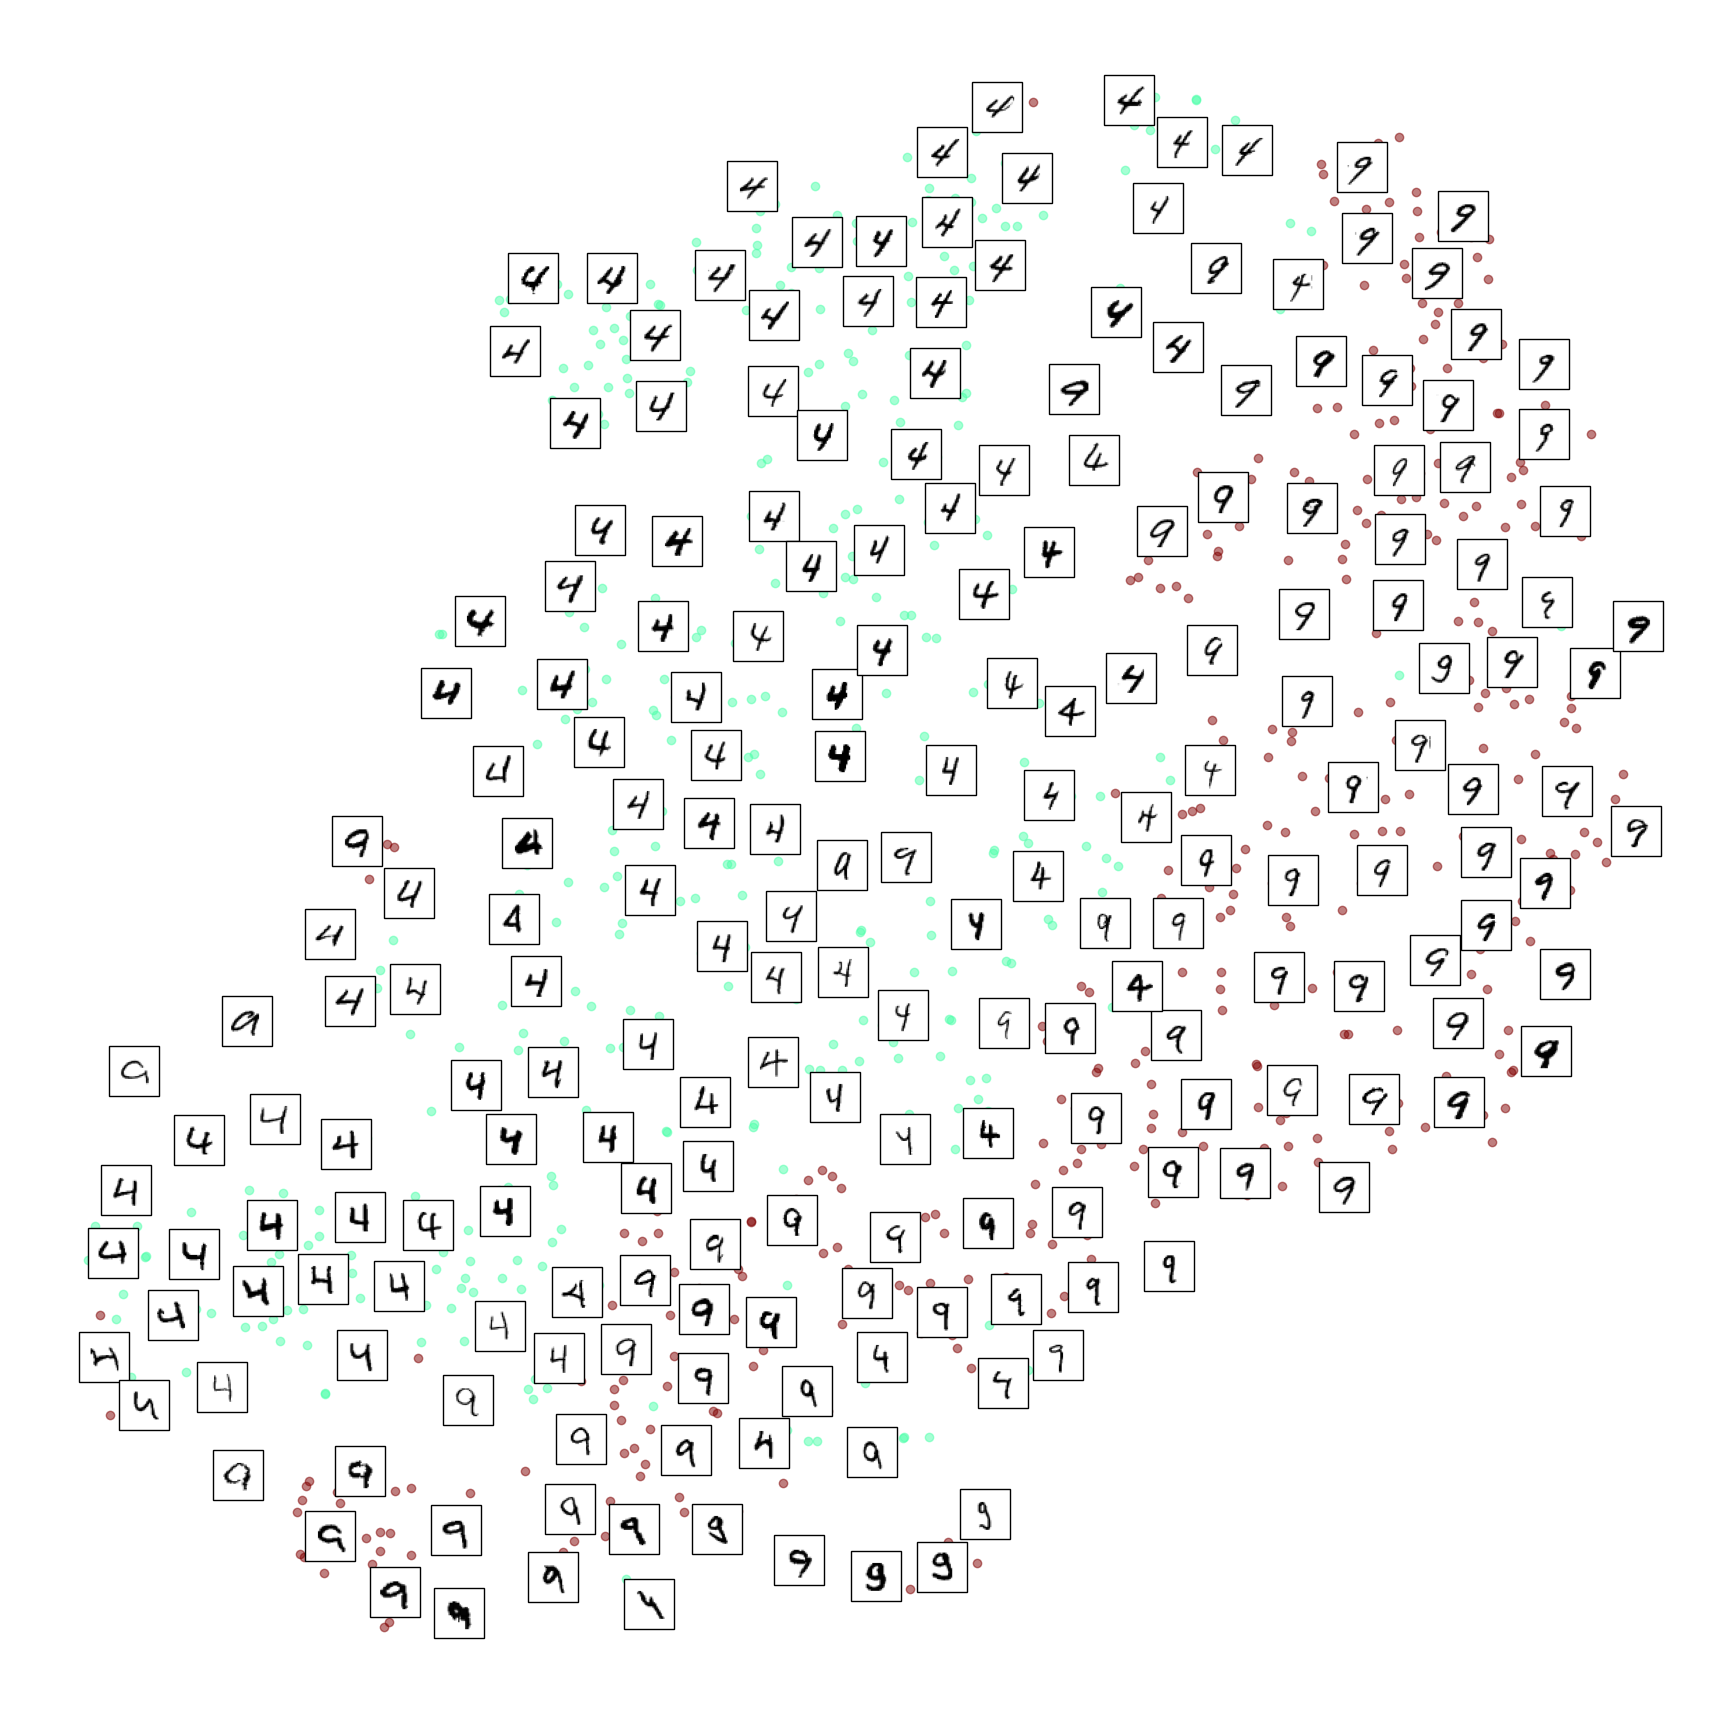

In [57]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

CPU times: user 253 ms, sys: 101 ms, total: 353 ms
Wall time: 308 ms


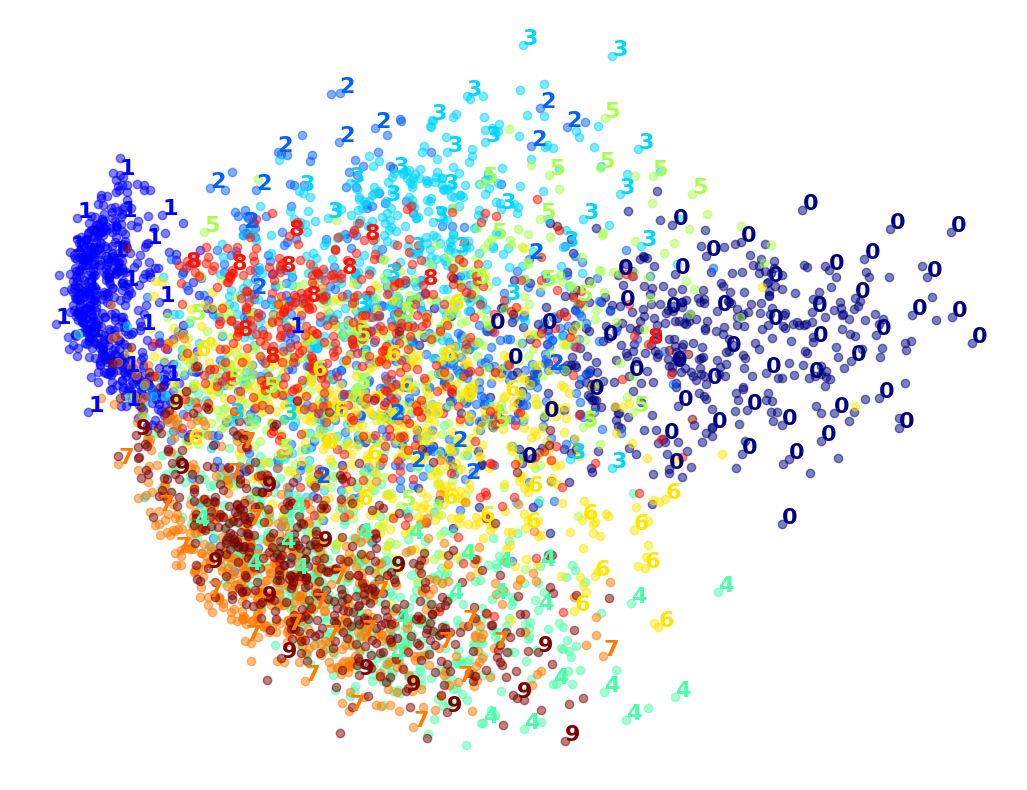

In [58]:
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_sample)
plot_digits(X_pca_reduced, y_sample)
plt.show()

CPU times: user 4.61 s, sys: 1.63 s, total: 6.24 s
Wall time: 3.92 s


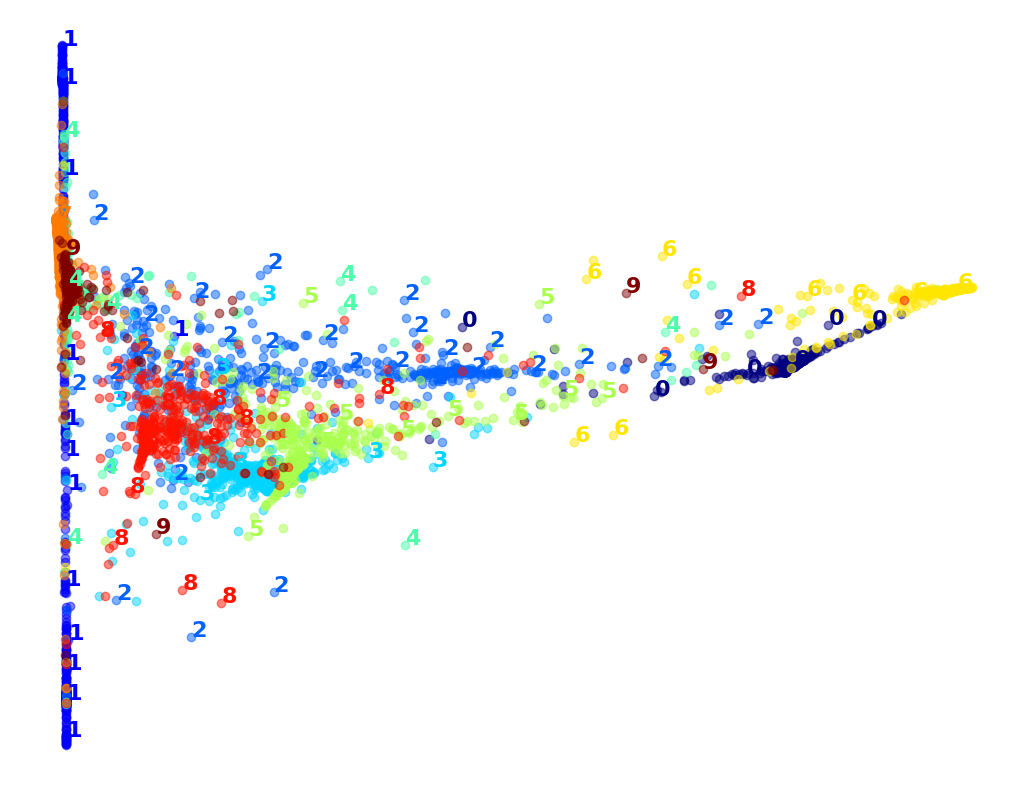

In [59]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
%time X_lle_reduced = lle.fit_transform(X_sample)
plot_digits(X_lle_reduced, y_sample)
plt.show()

CPU times: user 4.56 s, sys: 1.56 s, total: 6.12 s
Wall time: 3.4 s


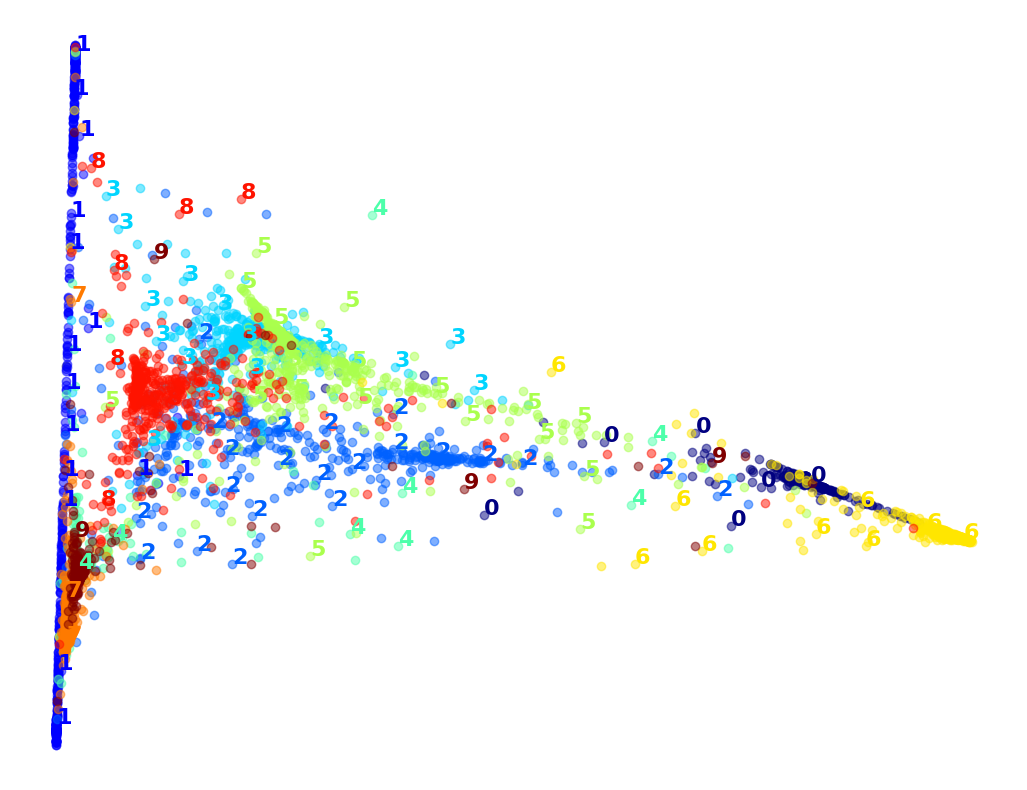

In [60]:
pca_lle = make_pipeline(PCA(n_components=0.95),
                        LocallyLinearEmbedding(n_components=2, random_state=42))

%time X_pca_lle_reduced = pca_lle.fit_transform(X_sample)
plot_digits(X_pca_lle_reduced, y_sample)
plt.show()

In [68]:
from sklearn.manifold import MDS # added ex-post
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

In [69]:
#ditto
mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [70]:
#ditto
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [71]:
# ditto
tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

In [73]:
# ditto
from matplotlib.colors import ListedColormap

In [75]:
# ditto
darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

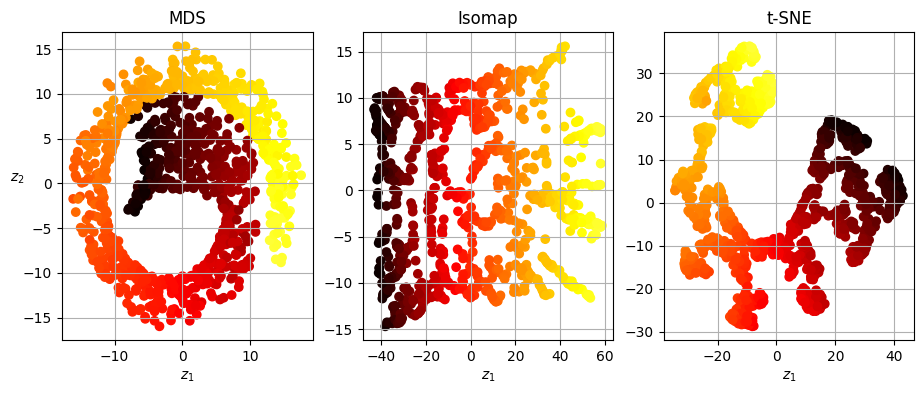

In [77]:
# ditto
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()

CPU times: user 9min 34s, sys: 5min 44s, total: 15min 18s
Wall time: 11min 58s


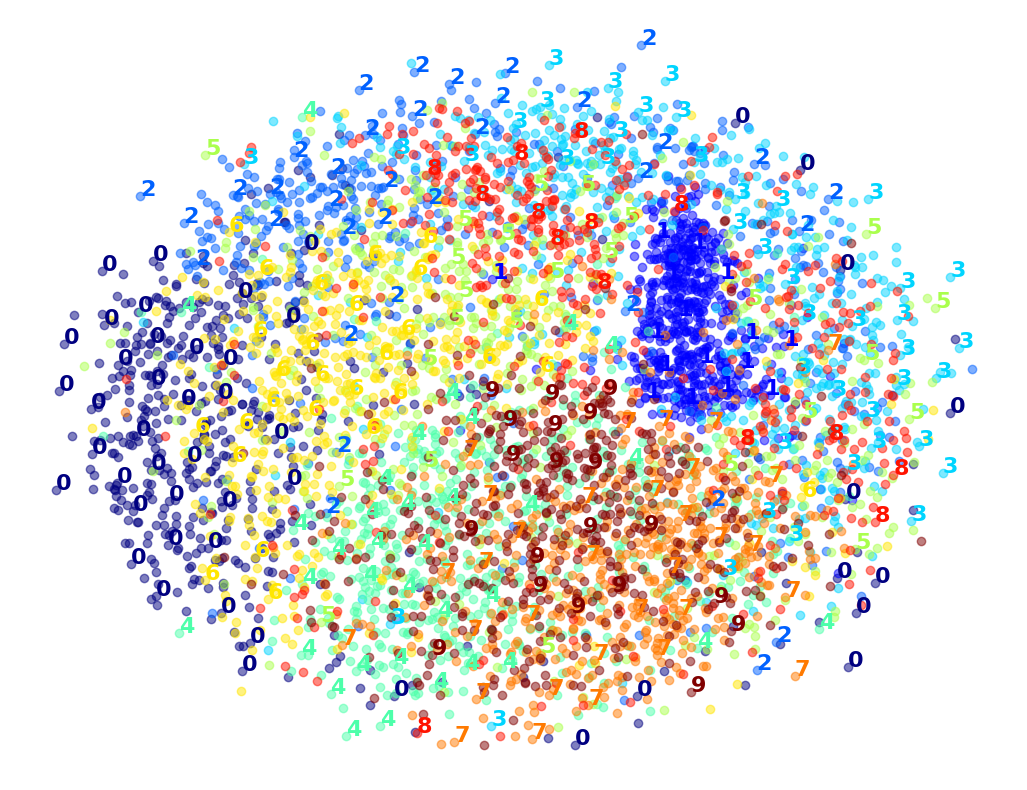

In [78]:
%time X_mds_reduced = MDS(n_components=2, normalized_stress=False, random_state=42).fit_transform(X_sample)
plot_digits(X_mds_reduced, y_sample)
plt.show()

CPU times: user 9min 35s, sys: 5min 44s, total: 15min 19s
Wall time: 11min 55s


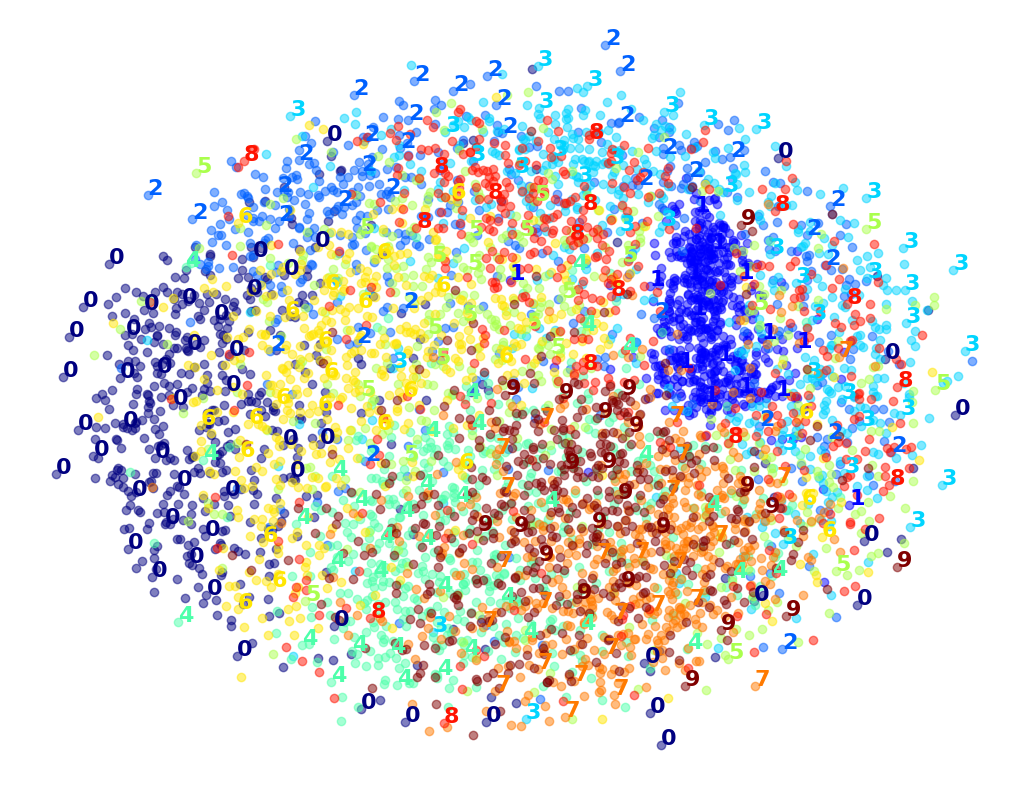

In [79]:
pca_mds = make_pipeline(
    PCA(n_components=0.95, random_state=42),
    MDS(n_components=2, normalized_stress=False, random_state=42)
)

%time X_pca_mds_reduced = pca_mds.fit_transform(X_sample)
plot_digits(X_pca_mds_reduced, y_sample)
plt.show()

In [80]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

CPU times: user 2.03 s, sys: 267 ms, total: 2.29 s
Wall time: 1.44 s


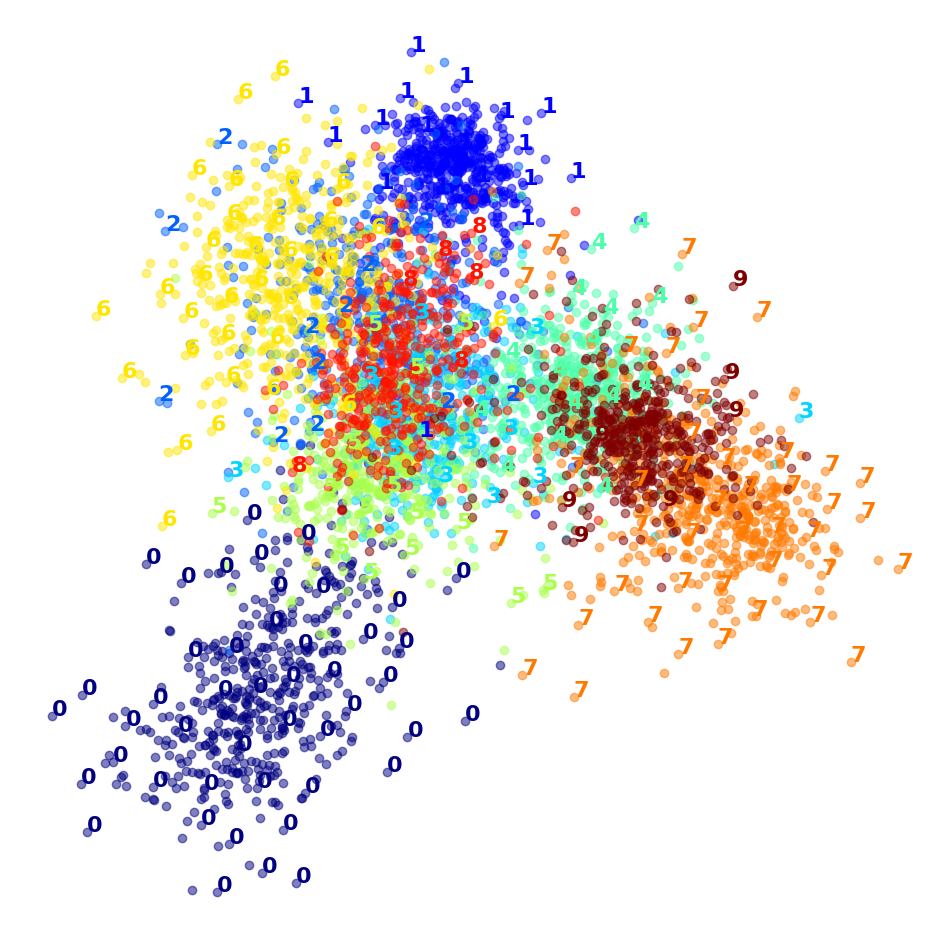

In [81]:
lda = LinearDiscriminantAnalysis(n_components=2)
%time X_lda_reduced = lda.fit_transform(X_sample, y_sample)
plot_digits(X_lda_reduced, y_sample, figsize=(12, 12))
plt.show()